## GDrive setup and libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import cv2
from skimage import io
from skimage import transform
from skimage import color
import pickle

import pickle
from tqdm.notebook import tqdm

from sklearn.metrics import mean_squared_error

import tensorflow as tf
import tensorflow_addons as tfa

ModuleNotFoundError: No module named 'cv2'

## Pandas dataframe to keep a track of errors for each folder:

In [ ]:
columns = ['Model', 'Model Type', 'A1_incorrect_preds', 'A2_incorrect_preds', 'A3_incorrect_preds', 'A4_incorrect_preds',
           'A1_MSE', 'A2_MSE', 'A3_MSE', 'A4_MSE', "Avg_MSE", 
           "A1_pred_greater_than_3", "A2_pred_greater_than_3", "A3_pred_greater_than_3", "A4_pred_greater_than_3"
           ]
error_df = pd.DataFrame(columns=columns)

## Load folder sets for evaluation

In [ ]:
# Load the images and counts
with open('Images.pkl', 'rb') as f:
  images = pickle.load(f)

with open('Counts.pkl', 'rb') as f:
  counts = pickle.load(f)


### Helper functions for images

In [ ]:
segnet_model = tf.keras.models.load_model("saved_models/saved_segmentation_model")

@tf.function
def get_images(image_path, size = [224, 224]):
    # Read the image path
    image = tf.io.decode_png(tf.io.read_file(image_path), channels = 3)
    image = tf.image.convert_image_dtype(image, tf.float64)
    # Resizing
    #image = tf.image.resize(image, [448, 448])  # Based on the values from the paper
    image = tf.image.resize(image, size)
    return image

@tf.function
def get_masked_image(image):
    #Get the mask from saved segmentation model
    #image = tf.image.resize(image, [224, 224])
    image_for_segmentation = tf.reshape(image, [1 ,224, 224, 3])
    mask = segnet_model(image_for_segmentation, training = False)[0]      # Return batch of 1 predicted image. Hence select the 0th element to get the prediction
    #mask = tf.image.resize(mask, [448, 448])   # Tensorshape = [448, 448, 1]

    # Convert the mask values to boolean
    threshold = 0.5
    cond = tf.greater(mask, tf.ones(tf.shape(mask))*threshold)
    boolean_mask = tf.where(cond, tf.ones(tf.shape(mask)), tf.zeros(tf.shape(mask)))

    # Concatenate the image with mask(as the 4th channel)
    #combined_image = tf.concat([mask, image], axis = -1)   # Tensorshape = [448, 448, 4]
    combined_image = tf.multiply(image, boolean_mask)    # Tensorshape = [448, 448, 3]
    combined_image = tf.image.resize(combined_image, [448, 448])
    
    return combined_image

@tf.function
def mask_concatenation(image):
    #Get the mask from saved segmentation model
    image_for_segmentation = tf.image.resize(image, [224, 224])
    image_for_segmentation = tf.reshape(image_for_segmentation, [1 ,224, 224, 3])
    #mask = segnet_model.predict(image_for_segmentation)
    mask = segnet_model(image_for_segmentation, training = False)      # Return batch of 1 predicted image. Hence select the 0th element to get the prediction
    mask = tf.image.resize(mask[0], [448, 448])   # Tensorshape = [448, 448, 1]

    # Concatenate the image with mask(as the 4th channel)
    combined_image = tf.concat([mask, image], axis = -1)   # Tensorshape = [448, 448, 4]

    return combined_image

@tf.function
def crop_and_resize_with_padding(combined_image):
    
    # Find the non zero indices
    cond = tf.not_equal(combined_image, 0)
    non_zero_indices = tf.where(cond)

    # Get the max and min indices for horizontal and vertical axis
    max_tensor = tf.math.reduce_max(non_zero_indices, axis=0)
    min_tensor = tf.math.reduce_min(non_zero_indices, axis=0)

    first_max = tf.gather(max_tensor, 0)
    second_max = tf.gather(max_tensor, 1)
    first_min = tf.gather(min_tensor, 0)
    second_min = tf.gather(min_tensor, 1)

    # Now crop the image and apply some padding
    cropped_image = combined_image[first_min:first_max,second_min:second_max,:]
    final_image = tf.image.resize_with_pad(cropped_image, 448, 448, method = "nearest")

    return final_image


## Helpers for getting error metrics and results

In [ ]:
def get_number_of_incorrect_preds(counts, predictions):
    return np.sum(np.not_equal(counts,predictions))

def get_MSE(counts, predictions):
    return mean_squared_error(counts, predictions)

def get_avg_MSE(mse_A1, mse_A2, mse_A3, mse_A4):
    return (mse_A1 + mse_A2 + mse_A3 + mse_A4) / 4 

def get_preds_greater_than_3(counts, predictions):
    return np.argwhere((counts-predictions >= 3) | (predictions-counts >=3))

def get_image_plots_from_indices(indices, image_list, predictions, counts, folder):
    if len(indices) == 0:
        print("No predictions where the predicted count is off by 3 or greater than 3 in folder", folder)
    else:      
        print("{} images in folder {} where the predicted count is off by 3 or greater than 3".format(len(indices), folder))
        for index in indices:
            print("Predicted: ", predictions[index][0])
            print("Ground_truth: ", counts[index][0])
            plt.imshow(image_list[index][0])
            plt.show()  
            print("-"*50)
    print("*"*50)
    print("*"*50)

In [ ]:
A1_image_paths, A1_counts = [],[]
A2_image_paths, A2_counts = [],[]
A3_image_paths, A3_counts = [],[]
A4_image_paths, A4_counts = [],[]

for image, count in zip(images, counts):
    folder = image.split("/")[1]

    if folder == 'A1':
        A1_image_paths.append(image)
        A1_counts.append(count)
    elif folder == 'A2':
        A2_image_paths.append(image)
        A2_counts.append(count)
    elif folder == 'A3':
        A3_image_paths.append(image)
        A3_counts.append(count)
    else:
        A4_image_paths.append(image)
        A4_counts.append(count)

print("Data points in folder A1:", len(A1_image_paths))
print("Data points in folder A2:", len(A2_image_paths))
print("Data points in folder A3:", len(A3_image_paths))
print("Data points in folder A4:", len(A4_image_paths))

Data points in folder A1: 128
Data points in folder A2: 31
Data points in folder A3: 27
Data points in folder A4: 624


## Predictions on sets

## 1.Transfer Learning Model

In [ ]:
A1_images = np.zeros(shape=(128, 256, 256, 3))
for i, (image, count) in enumerate(zip(A1_image_paths, A1_counts)):
     image = get_images(image, size = [256,256])
     A1_images[i] = image
A1_counts = np.array(A1_counts)

A2_images = np.zeros(shape=(31, 256, 256, 3))
for i, (image, count) in enumerate(zip(A2_image_paths, A2_counts)):
     image = get_images(image, size = [256,256])
     A2_images[i] = image
A2_counts = np.array(A2_counts)    

A3_images = np.zeros(shape=(27, 256, 256, 3))
for i, (image, count) in enumerate(zip(A3_image_paths, A3_counts)):
     image = get_images(image, size = [256,256])
     A3_images[i] = image
A3_counts = np.array(A3_counts)

A4_images = np.zeros(shape=(624, 256, 256, 3))
for i, (image, count) in enumerate(zip(A4_image_paths, A4_counts)):
     image = get_images(image, size = [256,256])
     A4_images[i] = image
A4_counts = np.array(A4_counts)

### a. DenseNet121

In [ ]:
# Load the model
model_path = "Transfer_learning_models/DenseNet121/"
model = tf.keras.models.load_model(model_path)

A1_preds = model.predict(A1_images)
A1_preds = A1_preds.reshape(A1_preds.shape[0])
A2_preds = model.predict(A2_images)
A2_preds = A2_preds.reshape(A2_preds.shape[0])
A3_preds = model.predict(A3_images)
A3_preds = A3_preds.reshape(A3_preds.shape[0])
A4_preds = model.predict(A4_images)
A4_preds = A4_preds.reshape(A4_preds.shape[0])

for i in range(len(A1_preds)):
    A1_preds[i] = round(A1_preds[i])
A1_preds = A1_preds.astype('int32')

for i in range(len(A2_preds)):
    A2_preds[i] = round(A2_preds[i])
A2_preds = A2_preds.astype('int32')

for i in range(len(A3_preds)):
    A3_preds[i] = round(A3_preds[i])
A3_preds = A3_preds.astype('int32')

for i in range(len(A4_preds)):
    A4_preds[i] = round(A4_preds[i])
A4_preds = A4_preds.astype('int32')

No predictions where the predicted count is off by 3 or greater than 3 in folder A1
**************************************************
**************************************************
3 images in folder A2 where the predicted count is off by 3 or greater than 3
Predicted:  11
Ground_truth:  15


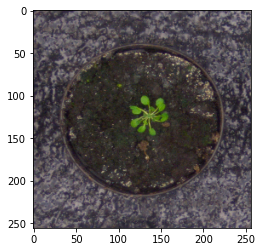

--------------------------------------------------
Predicted:  9
Ground_truth:  12


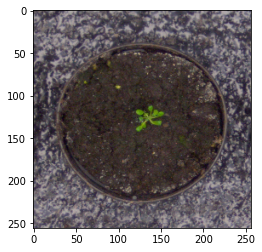

--------------------------------------------------
Predicted:  6
Ground_truth:  3


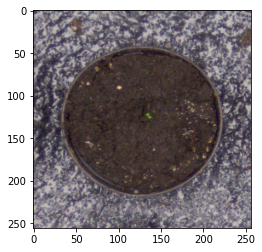

--------------------------------------------------
**************************************************
**************************************************
1 images in folder A3 where the predicted count is off by 3 or greater than 3
Predicted:  6
Ground_truth:  9


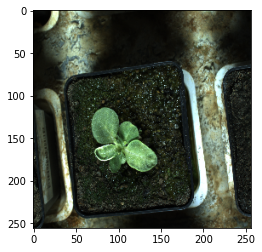

--------------------------------------------------
**************************************************
**************************************************
17 images in folder A4 where the predicted count is off by 3 or greater than 3
Predicted:  12
Ground_truth:  9


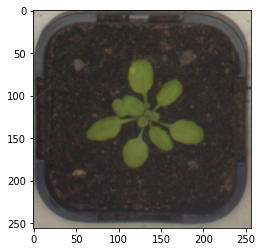

--------------------------------------------------
Predicted:  13
Ground_truth:  10


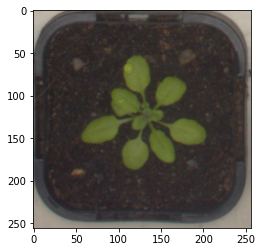

--------------------------------------------------
Predicted:  12
Ground_truth:  9


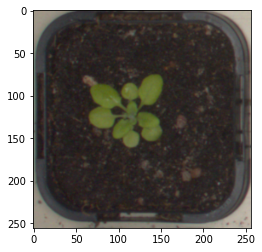

--------------------------------------------------
Predicted:  18
Ground_truth:  15


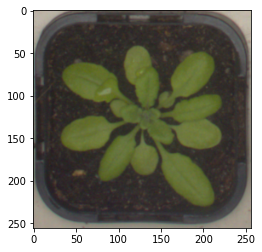

--------------------------------------------------
Predicted:  18
Ground_truth:  15


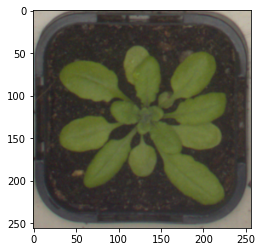

--------------------------------------------------
Predicted:  18
Ground_truth:  15


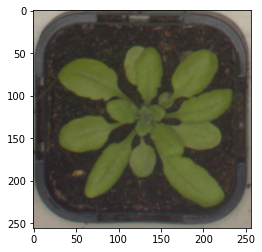

--------------------------------------------------
Predicted:  15
Ground_truth:  19


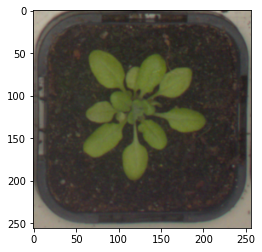

--------------------------------------------------
Predicted:  21
Ground_truth:  18


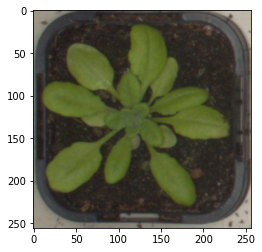

--------------------------------------------------
Predicted:  21
Ground_truth:  18


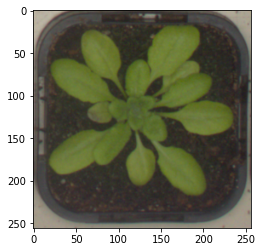

--------------------------------------------------
Predicted:  25
Ground_truth:  29


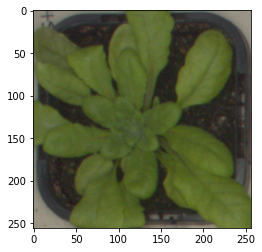

--------------------------------------------------
Predicted:  27
Ground_truth:  31


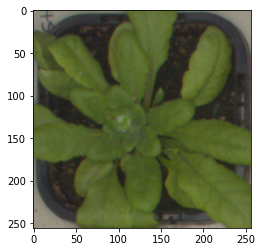

--------------------------------------------------
Predicted:  28
Ground_truth:  32


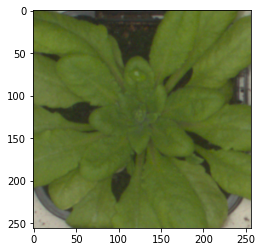

--------------------------------------------------
Predicted:  28
Ground_truth:  32


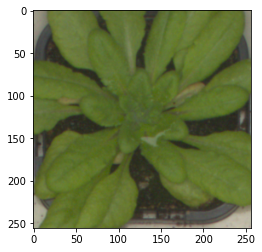

--------------------------------------------------
Predicted:  27
Ground_truth:  30


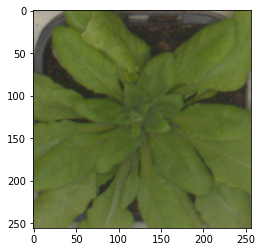

--------------------------------------------------
Predicted:  26
Ground_truth:  31


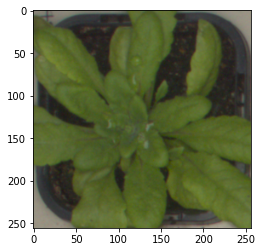

--------------------------------------------------
Predicted:  31
Ground_truth:  28


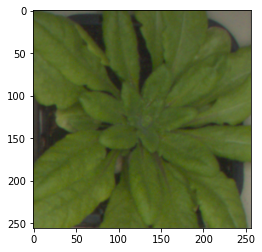

--------------------------------------------------
Predicted:  29
Ground_truth:  32


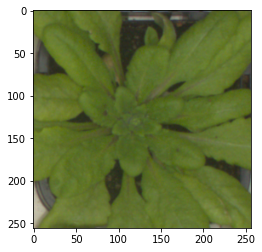

--------------------------------------------------
**************************************************
**************************************************


In [ ]:
# Get error metrics for each folder
mse_1 = get_MSE(A1_preds, A1_counts)
incorect_preds_1 = get_number_of_incorrect_preds(A1_preds, A1_counts)
preds_great_than_3_A1 = get_preds_greater_than_3(A1_preds, A1_counts)

mse_2 = get_MSE(A2_preds, A2_counts)
incorect_preds_2 = get_number_of_incorrect_preds(A2_preds, A2_counts)
preds_great_than_3_A2 = get_preds_greater_than_3(A2_preds, A2_counts)

mse_3 = get_MSE(A3_preds, A3_counts)
incorect_preds_3 = get_number_of_incorrect_preds(A3_preds, A3_counts)
preds_great_than_3_A3 = get_preds_greater_than_3(A3_preds, A3_counts)

mse_4 = get_MSE(A4_preds, A4_counts)
incorect_preds_4 = get_number_of_incorrect_preds(A4_preds, A4_counts)
preds_great_than_3_A4 = get_preds_greater_than_3(A4_preds, A4_counts)

avg_MSE = get_avg_MSE(mse_1, mse_2, mse_3, mse_4)

# Fill the error df 
error_df.loc[len(error_df.index)] = ["DenseNet121", "Transfer Learning",
                    incorect_preds_1, incorect_preds_2, incorect_preds_3, incorect_preds_4,
                    mse_1, mse_2, mse_3, mse_4, avg_MSE,
                    len(preds_great_than_3_A1), len(preds_great_than_3_A2), len(preds_great_than_3_A3), len(preds_great_than_3_A4)
                    ]

get_image_plots_from_indices(preds_great_than_3_A1, A1_images, A1_preds, A1_counts, "A1")
get_image_plots_from_indices(preds_great_than_3_A2, A2_images, A2_preds, A2_counts, "A2")
get_image_plots_from_indices(preds_great_than_3_A3, A3_images, A3_preds, A3_counts, "A3")
get_image_plots_from_indices(preds_great_than_3_A4, A4_images, A4_preds, A4_counts, "A4")

### b. ResNet50

In [ ]:
# Load the model
model_path = "Transfer_learning_models/ResNet50/"
model = tf.keras.models.load_model(model_path)

A1_preds = model.predict(A1_images)
A1_preds = A1_preds.reshape(A1_preds.shape[0])
A2_preds = model.predict(A2_images)
A2_preds = A2_preds.reshape(A2_preds.shape[0])
A3_preds = model.predict(A3_images)
A3_preds = A3_preds.reshape(A3_preds.shape[0])
A4_preds = model.predict(A4_images)
A4_preds = A4_preds.reshape(A4_preds.shape[0])

for i in range(len(A1_preds)):
    A1_preds[i] = round(A1_preds[i])
A1_preds = A1_preds.astype('int32')

for i in range(len(A2_preds)):
    A2_preds[i] = round(A2_preds[i])
A2_preds = A2_preds.astype('int32')

for i in range(len(A3_preds)):
    A3_preds[i] = round(A3_preds[i])
A3_preds = A3_preds.astype('int32')

for i in range(len(A4_preds)):
    A4_preds[i] = round(A4_preds[i])
A4_preds = A4_preds.astype('int32')

In [ ]:
# Get error metrics for each folder
mse_1 = get_MSE(A1_preds, A1_counts)
incorect_preds_1 = get_number_of_incorrect_preds(A1_preds, A1_counts)
preds_great_than_3_A1 = get_preds_greater_than_3(A1_preds, A1_counts)

mse_2 = get_MSE(A2_preds, A2_counts)
incorect_preds_2 = get_number_of_incorrect_preds(A2_preds, A2_counts)
preds_great_than_3_A2 = get_preds_greater_than_3(A2_preds, A2_counts)

mse_3 = get_MSE(A3_preds, A3_counts)
incorect_preds_3 = get_number_of_incorrect_preds(A3_preds, A3_counts)
preds_great_than_3_A3 = get_preds_greater_than_3(A3_preds, A3_counts)

mse_4 = get_MSE(A4_preds, A4_counts)
incorect_preds_4 = get_number_of_incorrect_preds(A4_preds, A4_counts)
preds_great_than_3_A4 = get_preds_greater_than_3(A4_preds, A4_counts)

avg_MSE = get_avg_MSE(mse_1, mse_2, mse_3, mse_4)

# Fill the error df 
error_df.loc[len(error_df.index)] = ["ResNet50", "Transfer Learning",
                    incorect_preds_1, incorect_preds_2, incorect_preds_3, incorect_preds_4,
                    mse_1, mse_2, mse_3, mse_4, avg_MSE,
                    len(preds_great_than_3_A1), len(preds_great_than_3_A2), len(preds_great_than_3_A3), len(preds_great_than_3_A4)
                    ]

get_image_plots_from_indices(preds_great_than_3_A1, A1_images, A1_preds, A1_counts, "A1")
get_image_plots_from_indices(preds_great_than_3_A2, A2_images, A2_preds, A2_counts, "A2")
get_image_plots_from_indices(preds_great_than_3_A3, A3_images, A3_preds, A3_counts, "A3")
get_image_plots_from_indices(preds_great_than_3_A4, A4_images, A4_preds, A4_counts, "A4")

### c. VGG16

In [ ]:
# Load the model
model_path = "Transfer_learning_models/VGG16/"
model = tf.keras.models.load_model(model_path)

A1_preds = model.predict(A1_images)
A1_preds = A1_preds.reshape(A1_preds.shape[0])
A2_preds = model.predict(A2_images)
A2_preds = A2_preds.reshape(A2_preds.shape[0])
A3_preds = model.predict(A3_images)
A3_preds = A3_preds.reshape(A3_preds.shape[0])
A4_preds = model.predict(A4_images)
A4_preds = A4_preds.reshape(A4_preds.shape[0])

for i in range(len(A1_preds)):
    A1_preds[i] = round(A1_preds[i])
A1_preds = A1_preds.astype('int32')

for i in range(len(A2_preds)):
    A2_preds[i] = round(A2_preds[i])
A2_preds = A2_preds.astype('int32')

for i in range(len(A3_preds)):
    A3_preds[i] = round(A3_preds[i])
A3_preds = A3_preds.astype('int32')

for i in range(len(A4_preds)):
    A4_preds[i] = round(A4_preds[i])
A4_preds = A4_preds.astype('int32')

In [ ]:
# Get error metrics for each folder
mse_1 = get_MSE(A1_preds, A1_counts)
incorect_preds_1 = get_number_of_incorrect_preds(A1_preds, A1_counts)
preds_great_than_3_A1 = get_preds_greater_than_3(A1_preds, A1_counts)

mse_2 = get_MSE(A2_preds, A2_counts)
incorect_preds_2 = get_number_of_incorrect_preds(A2_preds, A2_counts)
preds_great_than_3_A2 = get_preds_greater_than_3(A2_preds, A2_counts)

mse_3 = get_MSE(A3_preds, A3_counts)
incorect_preds_3 = get_number_of_incorrect_preds(A3_preds, A3_counts)
preds_great_than_3_A3 = get_preds_greater_than_3(A3_preds, A3_counts)

mse_4 = get_MSE(A4_preds, A4_counts)
incorect_preds_4 = get_number_of_incorrect_preds(A4_preds, A4_counts)
preds_great_than_3_A4 = get_preds_greater_than_3(A4_preds, A4_counts)

avg_MSE = get_avg_MSE(mse_1, mse_2, mse_3, mse_4)

# Fill the error df 
error_df.loc[len(error_df.index)] = ["VGG16", "Transfer Learning",
                    incorect_preds_1, incorect_preds_2, incorect_preds_3, incorect_preds_4,
                    mse_1, mse_2, mse_3, mse_4, avg_MSE,
                    len(preds_great_than_3_A1), len(preds_great_than_3_A2), len(preds_great_than_3_A3), len(preds_great_than_3_A4)
                    ]

get_image_plots_from_indices(preds_great_than_3_A1, A1_images, A1_preds, A1_counts, "A1")
get_image_plots_from_indices(preds_great_than_3_A2, A2_images, A2_preds, A2_counts, "A2")
get_image_plots_from_indices(preds_great_than_3_A3, A3_images, A3_preds, A3_counts, "A3")
get_image_plots_from_indices(preds_great_than_3_A4, A4_images, A4_preds, A4_counts, "A4")

In [ ]:
#error_df.to_csv("error_df.csv", index = False)
#error_df = pd.read_csv("error_df.csv")

## 2.Segmentation + Regression Models

### a. Combined Regression Model

The input for this model is a 4 channel (SRGB) image

In [ ]:
A1_set = tf.data.Dataset.from_tensor_slices((A1_image_paths))
A2_set = tf.data.Dataset.from_tensor_slices((A2_image_paths))
A3_set = tf.data.Dataset.from_tensor_slices((A3_image_paths))
A4_set = tf.data.Dataset.from_tensor_slices((A4_image_paths))

A1_counts = np.array(A1_counts)
A2_counts = np.array(A2_counts)
A3_counts = np.array(A3_counts)
A4_counts = np.array(A4_counts)

A1_images = A1_set.map(get_images)
A2_images = A2_set.map(get_images)
A3_images = A3_set.map(get_images)
A4_images = A4_set.map(get_images)

A1_input = A1_images.map(mask_concatenation).batch(1)
A2_input = A2_images.map(mask_concatenation).batch(1)
A3_input = A3_images.map(mask_concatenation).batch(1)
A4_input = A4_images.map(mask_concatenation).batch(1)

In [ ]:
# Load the model
model_path = "Checkpoints/Combined_regression_model_4_channel_input/"
model = tf.keras.models.load_model(model_path)

A1_preds = model.predict(A1_input)
A1_preds = A1_preds.reshape(A1_preds.shape[0])
A2_preds = model.predict(A2_input)
A2_preds = A2_preds.reshape(A2_preds.shape[0])
A3_preds = model.predict(A3_input)
A3_preds = A3_preds.reshape(A3_preds.shape[0])
A4_preds = model.predict(A4_input)
A4_preds = A4_preds.reshape(A4_preds.shape[0])

for i in range(len(A1_preds)):
    A1_preds[i] = round(A1_preds[i])
A1_preds = A1_preds.astype('int32')

for i in range(len(A2_preds)):
    A2_preds[i] = round(A2_preds[i])
A2_preds = A2_preds.astype('int32')

for i in range(len(A3_preds)):
    A3_preds[i] = round(A3_preds[i])
A3_preds = A3_preds.astype('int32')

for i in range(len(A4_preds)):
    A4_preds[i] = round(A4_preds[i])
A4_preds = A4_preds.astype('int32')

A1_images = list(A1_images.as_numpy_iterator())
A2_images = list(A2_images.as_numpy_iterator())
A3_images = list(A3_images.as_numpy_iterator())
A4_images = list(A4_images.as_numpy_iterator())

A1_images = np.array(A1_images)
A2_images = np.array(A2_images)
A3_images = np.array(A3_images)
A4_images = np.array(A4_images)

In [ ]:
# Get error metrics for each folder
mse_1 = get_MSE(A1_preds, A1_counts)
incorect_preds_1 = get_number_of_incorrect_preds(A1_preds, A1_counts)
preds_great_than_3_A1 = get_preds_greater_than_3(A1_preds, A1_counts)

mse_2 = get_MSE(A2_preds, A2_counts)
incorect_preds_2 = get_number_of_incorrect_preds(A2_preds, A2_counts)
preds_great_than_3_A2 = get_preds_greater_than_3(A2_preds, A2_counts)

mse_3 = get_MSE(A3_preds, A3_counts)
incorect_preds_3 = get_number_of_incorrect_preds(A3_preds, A3_counts)
preds_great_than_3_A3 = get_preds_greater_than_3(A3_preds, A3_counts)

mse_4 = get_MSE(A4_preds, A4_counts)
incorect_preds_4 = get_number_of_incorrect_preds(A4_preds, A4_counts)
preds_great_than_3_A4 = get_preds_greater_than_3(A4_preds, A4_counts)

avg_MSE = get_avg_MSE(mse_1, mse_2, mse_3, mse_4)

# Fill the error df 
error_df.loc[len(error_df.index)] = ["Combined Regression Model (4 channel SRGB input)", "Segmentation + Regression",
                    incorect_preds_1, incorect_preds_2, incorect_preds_3, incorect_preds_4,
                    mse_1, mse_2, mse_3, mse_4, avg_MSE,
                    len(preds_great_than_3_A1), len(preds_great_than_3_A2), len(preds_great_than_3_A3), len(preds_great_than_3_A4)
                    ]

get_image_plots_from_indices(preds_great_than_3_A1, A1_images, A1_preds, A1_counts, "A1")
get_image_plots_from_indices(preds_great_than_3_A2, A2_images, A2_preds, A2_counts, "A2")
get_image_plots_from_indices(preds_great_than_3_A3, A3_images, A3_preds, A3_counts, "A3")
get_image_plots_from_indices(preds_great_than_3_A4, A4_images, A4_preds, A4_counts, "A4")

In [ ]:
#error_df.to_csv("error_df.csv", index = False)
#error_df = pd.read_csv("error_df.csv")

### b. Combined Regression Model - Only leaves

The input for this model is a masked image of 3(RGB) channels

In [ ]:
A1_set = tf.data.Dataset.from_tensor_slices((A1_image_paths))
A2_set = tf.data.Dataset.from_tensor_slices((A2_image_paths))
A3_set = tf.data.Dataset.from_tensor_slices((A3_image_paths))
A4_set = tf.data.Dataset.from_tensor_slices((A4_image_paths))

A1_counts = np.array(A1_counts)
A2_counts = np.array(A2_counts)
A3_counts = np.array(A3_counts)
A4_counts = np.array(A4_counts)

A1_images = A1_set.map(get_images)
A2_images = A2_set.map(get_images)
A3_images = A3_set.map(get_images)
A4_images = A4_set.map(get_images)

A1_input = A1_images.map(get_masked_image).batch(1)
A2_input = A2_images.map(get_masked_image).batch(1)
A3_input = A3_images.map(get_masked_image).batch(1)
A4_input = A4_images.map(get_masked_image).batch(1)

In [ ]:
# Load the model
model_path = "Checkpoints/Combined_regression_model_masked_input/"
model = tf.keras.models.load_model(model_path)

A1_preds = model.predict(A1_input)
A1_preds = A1_preds.reshape(A1_preds.shape[0])
A2_preds = model.predict(A2_input)
A2_preds = A2_preds.reshape(A2_preds.shape[0])
A3_preds = model.predict(A3_input)
A3_preds = A3_preds.reshape(A3_preds.shape[0])
A4_preds = model.predict(A4_input)
A4_preds = A4_preds.reshape(A4_preds.shape[0])

for i in range(len(A1_preds)):
    A1_preds[i] = round(A1_preds[i])
A1_preds = A1_preds.astype('int32')

for i in range(len(A2_preds)):
    A2_preds[i] = round(A2_preds[i])
A2_preds = A2_preds.astype('int32')

for i in range(len(A3_preds)):
    A3_preds[i] = round(A3_preds[i])
A3_preds = A3_preds.astype('int32')

for i in range(len(A4_preds)):
    A4_preds[i] = round(A4_preds[i])
A4_preds = A4_preds.astype('int32')

A1_images = np.array(list(A1_images.as_numpy_iterator()))
A2_images = np.array(list(A2_images.as_numpy_iterator()))
A3_images = np.array(list(A3_images.as_numpy_iterator()))
A4_images = np.array(list(A4_images.as_numpy_iterator()))

In [ ]:
# Get error metrics for each folder
mse_1 = get_MSE(A1_preds, A1_counts)
incorect_preds_1 = get_number_of_incorrect_preds(A1_preds, A1_counts)
preds_great_than_3_A1 = get_preds_greater_than_3(A1_preds, A1_counts)

mse_2 = get_MSE(A2_preds, A2_counts)
incorect_preds_2 = get_number_of_incorrect_preds(A2_preds, A2_counts)
preds_great_than_3_A2 = get_preds_greater_than_3(A2_preds, A2_counts)

mse_3 = get_MSE(A3_preds, A3_counts)
incorect_preds_3 = get_number_of_incorrect_preds(A3_preds, A3_counts)
preds_great_than_3_A3 = get_preds_greater_than_3(A3_preds, A3_counts)

mse_4 = get_MSE(A4_preds, A4_counts)
incorect_preds_4 = get_number_of_incorrect_preds(A4_preds, A4_counts)
preds_great_than_3_A4 = get_preds_greater_than_3(A4_preds, A4_counts)

avg_MSE = get_avg_MSE(mse_1, mse_2, mse_3, mse_4)

# Fill the error df 
error_df.loc[len(error_df.index)] = ["Combined Regression Model- Only leaves (Masked input)", "Segmentation + Regression",
                    incorect_preds_1, incorect_preds_2, incorect_preds_3, incorect_preds_4,
                    mse_1, mse_2, mse_3, mse_4, avg_MSE,
                    len(preds_great_than_3_A1), len(preds_great_than_3_A2), len(preds_great_than_3_A3), len(preds_great_than_3_A4)
                    ]

get_image_plots_from_indices(preds_great_than_3_A1, A1_images, A1_preds, A1_counts, "A1")
get_image_plots_from_indices(preds_great_than_3_A2, A2_images, A2_preds, A2_counts, "A2")
get_image_plots_from_indices(preds_great_than_3_A3, A3_images, A3_preds, A3_counts, "A3")
get_image_plots_from_indices(preds_great_than_3_A4, A4_images, A4_preds, A4_counts, "A4")

In [ ]:
#error_df.to_csv("error_df.csv", index = False)
#error_df = pd.read_csv("error_df.csv")

### c. Combined Regression Model -- Cropped leaves

The input for this model is a masked image of 3(RGB) channels and the leaves are cropped and resized

In [ ]:
A1_set = tf.data.Dataset.from_tensor_slices((A1_image_paths))
A2_set = tf.data.Dataset.from_tensor_slices((A2_image_paths))
A3_set = tf.data.Dataset.from_tensor_slices((A3_image_paths))
A4_set = tf.data.Dataset.from_tensor_slices((A4_image_paths))

A1_counts = np.array(A1_counts)
A2_counts = np.array(A2_counts)
A3_counts = np.array(A3_counts)
A4_counts = np.array(A4_counts)

A1_images = A1_set.map(get_images)
A2_images = A2_set.map(get_images)
A3_images = A3_set.map(get_images)
A4_images = A4_set.map(get_images)

A1_input = A1_images.map(get_masked_image).map(crop_and_resize_with_padding).batch(1)
A2_input = A2_images.map(get_masked_image).map(crop_and_resize_with_padding).batch(1)
A3_input = A3_images.map(get_masked_image).map(crop_and_resize_with_padding).batch(1)
A4_input = A4_images.map(get_masked_image).map(crop_and_resize_with_padding).batch(1)

In [ ]:
# Load the model
model_path = "Checkpoints/Cropped_leaves_model"
model = tf.keras.models.load_model(model_path)

A1_preds = model.predict(A1_input)
A1_preds = A1_preds.reshape(A1_preds.shape[0])
A2_preds = model.predict(A2_input)
A2_preds = A2_preds.reshape(A2_preds.shape[0])
A3_preds = model.predict(A3_input)
A3_preds = A3_preds.reshape(A3_preds.shape[0])
A4_preds = model.predict(A4_input)
A4_preds = A4_preds.reshape(A4_preds.shape[0])

for i in range(len(A1_preds)):
    A1_preds[i] = round(A1_preds[i])
A1_preds = A1_preds.astype('int32')

for i in range(len(A2_preds)):
    A2_preds[i] = round(A2_preds[i])
A2_preds = A2_preds.astype('int32')

for i in range(len(A3_preds)):
    A3_preds[i] = round(A3_preds[i])
A3_preds = A3_preds.astype('int32')

for i in range(len(A4_preds)):
    A4_preds[i] = round(A4_preds[i])
A4_preds = A4_preds.astype('int32')

A1_images = np.array(list(A1_images.as_numpy_iterator()))
A2_images = np.array(list(A2_images.as_numpy_iterator()))
A3_images = np.array(list(A3_images.as_numpy_iterator()))
A4_images = np.array(list(A4_images.as_numpy_iterator()))

In [ ]:
# Get error metrics for each folder
mse_1 = get_MSE(A1_preds, A1_counts)
incorect_preds_1 = get_number_of_incorrect_preds(A1_preds, A1_counts)
preds_great_than_3_A1 = get_preds_greater_than_3(A1_preds, A1_counts)

mse_2 = get_MSE(A2_preds, A2_counts)
incorect_preds_2 = get_number_of_incorrect_preds(A2_preds, A2_counts)
preds_great_than_3_A2 = get_preds_greater_than_3(A2_preds, A2_counts)

mse_3 = get_MSE(A3_preds, A3_counts)
incorect_preds_3 = get_number_of_incorrect_preds(A3_preds, A3_counts)
preds_great_than_3_A3 = get_preds_greater_than_3(A3_preds, A3_counts)

mse_4 = get_MSE(A4_preds, A4_counts)
incorect_preds_4 = get_number_of_incorrect_preds(A4_preds, A4_counts)
preds_great_than_3_A4 = get_preds_greater_than_3(A4_preds, A4_counts)

avg_MSE = get_avg_MSE(mse_1, mse_2, mse_3, mse_4)

# Fill the error df 
error_df.loc[len(error_df.index)] = ["Combined Regression Model- cropped leaves (Masked input)", "Segmentation + Regression",
                    incorect_preds_1, incorect_preds_2, incorect_preds_3, incorect_preds_4,
                    mse_1, mse_2, mse_3, mse_4, avg_MSE,
                    len(preds_great_than_3_A1), len(preds_great_than_3_A2), len(preds_great_than_3_A3), len(preds_great_than_3_A4)
                    ]

get_image_plots_from_indices(preds_great_than_3_A1, A1_images, A1_preds, A1_counts, "A1")
get_image_plots_from_indices(preds_great_than_3_A2, A2_images, A2_preds, A2_counts, "A2")
get_image_plots_from_indices(preds_great_than_3_A3, A3_images, A3_preds, A3_counts, "A3")
get_image_plots_from_indices(preds_great_than_3_A4, A4_images, A4_preds, A4_counts, "A4")

In [ ]:
error_df['total_pred_greater_than_3'] = (error_df['A1_pred_greater_than_3'] + error_df['A2_pred_greater_than_3']
                                        + error_df['A3_pred_greater_than_3'] + error_df['A4_pred_greater_than_3'])

error_df['total_incorrect_preds'] = (error_df['A1_incorrect_preds'] + error_df['A2_incorrect_preds']
                                     + error_df['A3_incorrect_preds'] + error_df['A4_incorrect_preds'])

In [ ]:
error_df.at[3, 'Model'] = "SRGB model"
error_df.at[4, 'Model'] = "Masked input model"
error_df.at[5, 'Model'] = "Cropped input model"

In [ ]:
error_df

,Model,Model Type,A1_incorrect_preds,A2_incorrect_preds,A3_incorrect_preds,A4_incorrect_preds,A1_MSE,A2_MSE,A3_MSE,A4_MSE,Avg_MSE,A1_pred_greater_than_3,A2_pred_greater_than_3,A3_pred_greater_than_3,A4_pred_greater_than_3,total_pred_greater_than_3,total_incorrect_preds
0,DenseNet121,Transfer Learning,60,28,19,395,0.773438,2.870968,2.000000,1.230769,1.718794,0,3,1,17,21,502
1,ResNet50,Transfer Learning,83,23,21,413,1.031250,4.129032,1.740741,1.447115,2.087035,2,5,1,27,35,540
2,VGG16,Transfer Learning,95,26,15,395,2.476562,5.096774,1.222222,1.519231,2.578697,17,11,0,30,58,531
3,SRGB model,Segmentation + Regression,95,23,21,424,2.398438,4.483871,2.925926,1.862179,2.917603,12,7,5,37,61,563
4,Masked input model,Segmentation + Regression,112,24,24,475,6.968750,7.548387,4.148148,2.967949,5.408308,45,9,5,56,115,635
5,Cropped input model,Segmentation + Regression,104,24,24,494,4.203125,2.935484,26.148148,4.363782,9.412635,23,3,9,121,156,646


In [2]:
#error_df.to_csv("error_df.csv", index = False)
error_df = pd.read_csv("error_df.csv")

## Plots:

Note: Since the incorrect predictions in directory A4 is comparitively higher for most cases, the plot would not be interpretable if all 4 directories are plotted over a single plot

### Directory Description:

- Directories A1 and A2 contain
Arabidopsis plant images. The images were taken in groups and then cropped to a single plant. The directories A1 and A2 contain these cropped images.
- Directory A3 contains 27 Tobacco images 
- A4 also contains Arabidopsis plant images that were captured using a time-lapse camera.


### Results based on the Directories:

#### Directory A1

Directory A1 contains 128 images with medium sized leaves. 

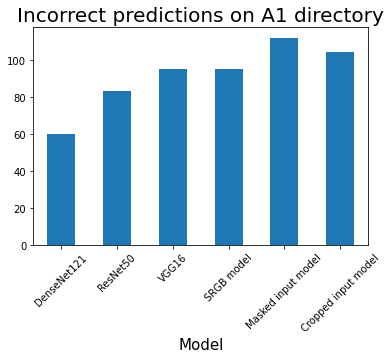

In [3]:
error_df.plot(kind='bar', x="Model", y="A1_incorrect_preds", legend=False)
plt.xticks(rotation=45)
plt.title("Incorrect predictions on A1 directory", fontsize = 20)
plt.xlabel("Model" ,fontsize = 15)
plt.show()

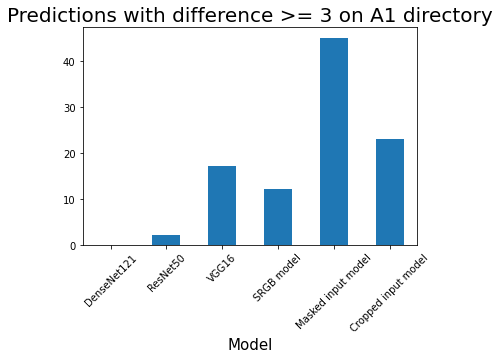

In [7]:
error_df.plot(kind='bar', x="Model", y="A1_pred_greater_than_3", legend=False)
plt.xticks(rotation=45)
plt.title("Predictions with difference >= 3 on A1 directory", fontsize = 20)
plt.xlabel("Model" ,fontsize = 15)
plt.show()

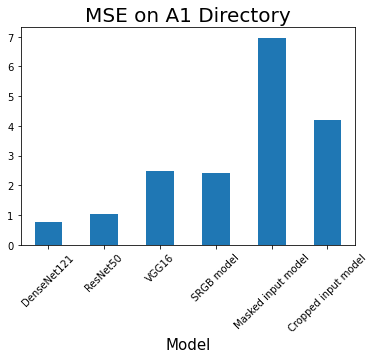

In [5]:
error_df.plot(kind='bar', x="Model", y="A1_MSE", legend=False)
plt.xticks(rotation=45)
plt.title("MSE on A1 Directory", fontsize = 20)
plt.xlabel("Model" ,fontsize = 15)
plt.show()

#### Directory A2

Directory A2 contains 31 images that are a mixture of small, medium and large sized leaves

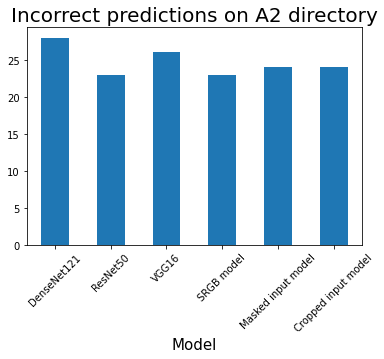

In [6]:
error_df.plot(kind='bar', x="Model", y="A2_incorrect_preds", legend=False)
plt.xticks(rotation=45)
plt.title("Incorrect predictions on A2 directory", fontsize = 20)
plt.xlabel("Model" ,fontsize = 15)
plt.show()

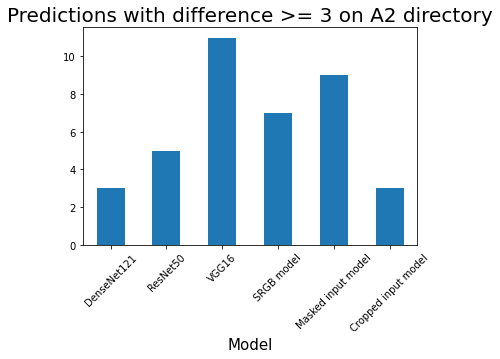

In [8]:
error_df.plot(kind='bar', x="Model", y="A2_pred_greater_than_3", legend=False)
plt.xticks(rotation=45)
plt.title("Predictions with difference >= 3 on A2 directory", fontsize = 20)
plt.xlabel("Model" ,fontsize = 15)
plt.show()

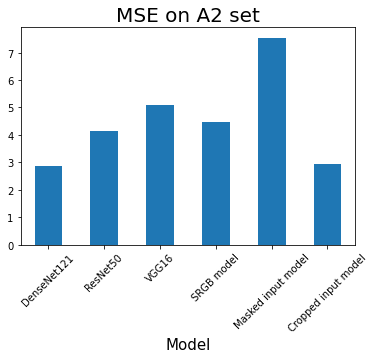

In [9]:
error_df.plot(kind='bar', x="Model", y="A2_MSE", legend=False)
plt.xticks(rotation=45)
plt.title("MSE on A2 set", fontsize = 20)
plt.xlabel("Model" ,fontsize = 15)
plt.show()

#### Directory A3

Directory A3 contains 27 images of small sized tobacco leaves.

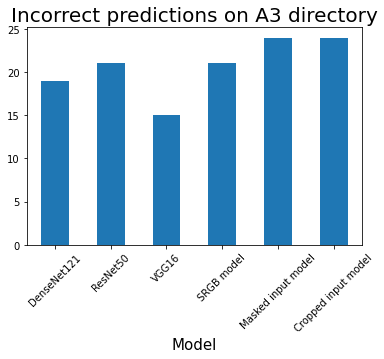

In [10]:
error_df.plot(kind='bar', x="Model", y="A3_incorrect_preds", legend=False)
plt.xticks(rotation=45)
plt.title("Incorrect predictions on A3 directory", fontsize = 20)
plt.xlabel("Model" ,fontsize = 15)
plt.show()

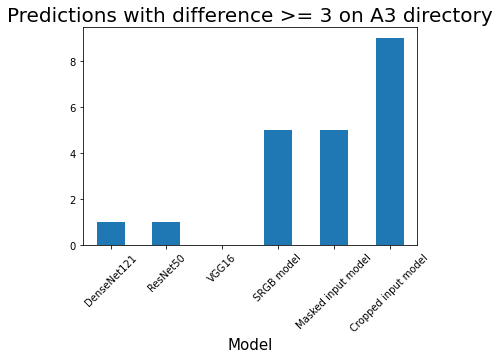

In [11]:
error_df.plot(kind='bar', x="Model", y="A3_pred_greater_than_3", legend=False)
plt.xticks(rotation=45)
plt.title("Predictions with difference >= 3 on A3 directory", fontsize = 20)
plt.xlabel("Model" ,fontsize = 15)
plt.show()

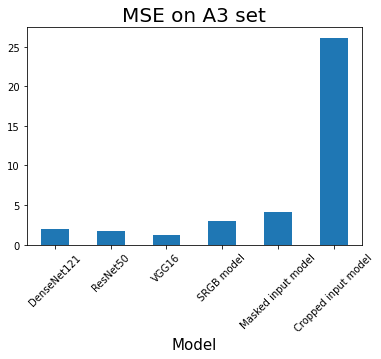

In [12]:
error_df.plot(kind='bar', x="Model", y="A3_MSE", legend=False)
plt.xticks(rotation=45)
plt.title("MSE on A3 set", fontsize = 20)
plt.xlabel("Model" ,fontsize = 15)
plt.show()

#### Directory A4

Directory A4 contains 624 images that include small, medium and large sized leaves 

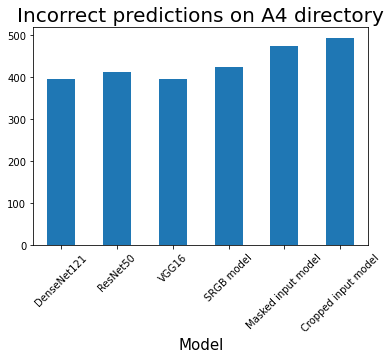

In [13]:
error_df.plot(kind='bar', x="Model", y="A4_incorrect_preds", legend=False)
plt.xticks(rotation=45)
plt.title("Incorrect predictions on A4 directory", fontsize = 20)
plt.xlabel("Model" ,fontsize = 15)
plt.show()

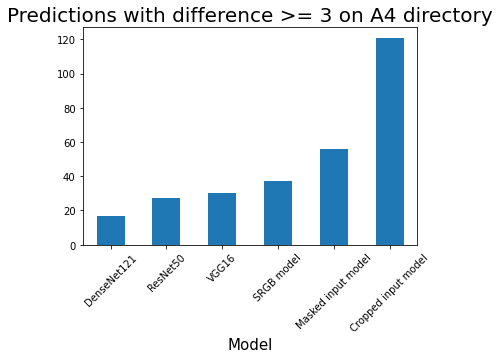

In [14]:
error_df.plot(kind='bar', x="Model", y="A4_pred_greater_than_3", legend=False)
plt.xticks(rotation=45)
plt.title("Predictions with difference >= 3 on A4 directory", fontsize = 20)
plt.xlabel("Model" ,fontsize = 15)
plt.show()

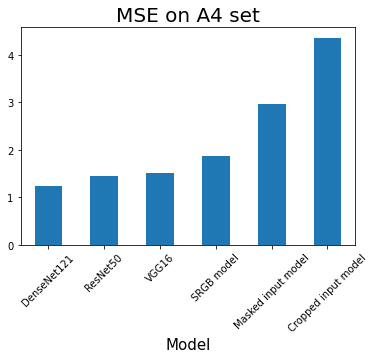

In [15]:
error_df.plot(kind='bar', x="Model", y="A4_MSE", legend=False)
plt.xticks(rotation=45)
plt.title("MSE on A4 set", fontsize = 20)
plt.xlabel("Model" ,fontsize = 15)
plt.show()

### Overall predictions and results

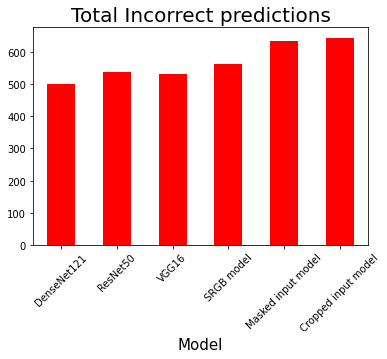

In [ ]:
error_df.plot(kind='bar', x="Model", y="total_incorrect_preds", color = "red", legend=False)
plt.xticks(rotation=45)
plt.title("Total Incorrect predictions", fontsize = 20)
plt.xlabel("Model" ,fontsize = 15)
plt.show()

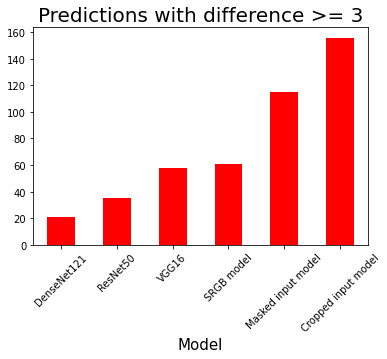

In [ ]:
error_df.plot(kind='bar', x="Model", y="total_pred_greater_than_3", color = "red", legend=False)
plt.xticks(rotation=45)
plt.title("Predictions with difference >= 3", fontsize = 20)
plt.xlabel("Model" ,fontsize = 15)
plt.show()

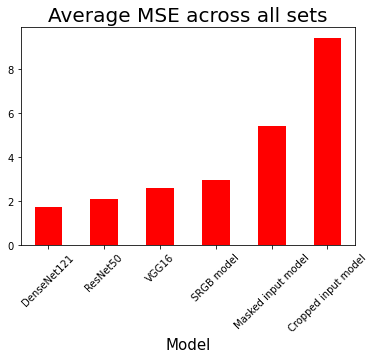

In [ ]:
error_df.plot(kind='bar', x="Model", y="Avg_MSE", color = "red", legend=False)
plt.xticks(rotation=45)
plt.title("Average MSE across all sets", fontsize = 20)
plt.xlabel("Model" ,fontsize = 15)
plt.show()

## Conclusion:

In [ ]:
error_df[['Model', 'Model Type', 'A1_MSE', 'A2_MSE', 'A3_MSE', 'A4_MSE', 'Avg_MSE']]

,Model,Model Type,A1_MSE,A2_MSE,A3_MSE,A4_MSE,Avg_MSE
0,DenseNet121,Transfer Learning,0.773438,2.870968,2.000000,1.230769,1.718794
1,ResNet50,Transfer Learning,1.031250,4.129032,1.740741,1.447115,2.087035
2,VGG16,Transfer Learning,2.476562,5.096774,1.222222,1.519231,2.578697
3,SRGB model,Segmentation + Regression,2.398438,4.483871,2.925926,1.862179,2.917603
4,Masked input model,Segmentation + Regression,6.968750,7.548387,4.148148,2.967949,5.408308
5,Cropped input model,Segmentation + Regression,4.203125,2.935484,26.148148,4.363782,9.412635


- As observed, transfer learning models gave better results than Segmentation + Regression models.
- Pre-trained Densenet121 model further trained on the given data gave the best results.
- Among the Segmentation + Regression Models, model with SRGB channel input gave similar results as compared to some of the transfer learning models.
- Model with cropped input gave the worst results. A possible reason for this might be the fact that the data images were already cropped and of slightly low quality and hence again cropping and resizing the leaves mask did not help the cause. 